**Helpful Documentation**

*Documentation for stock library:
https://readthedocs.org/projects/pandas-datareader/downloads/pdf/latest/

*Documentation for dataframes below:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html

*Documentation for plotting pretty graphs below:
https://matplotlib.org/3.2.1/tutorials/introductory/sample_plots.html

In [0]:
# Install required Libraries
!pip install pandas_datareader

In [233]:
## Import Libraries and set information
from pandas_datareader import data
from datetime import date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
import tensorflow as tf

# Get Current Date
today = date.today()
currentDate = today.strftime("%Y/%m/%d")

# Set Info
start_date = '2018-01-01'
end_date = currentDate
stockName = 'TSLA'

# Get the data
stockData = data.get_data_yahoo(stockName, start_date, end_date)
stockData.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,322.109985,311.000000,312.000000,320.529999,4352200,320.529999
2018-01-03,325.250000,315.549988,321.000000,317.250000,4521500,317.250000
2018-01-04,318.549988,305.679993,312.869995,314.619995,9946300,314.619995
2018-01-05,317.239990,312.000000,316.619995,316.579987,4591200,316.579987
2018-01-08,337.019989,315.500000,316.000000,336.410004,9859400,336.410004


Plot raw results

No handles with labels found to put in legend.


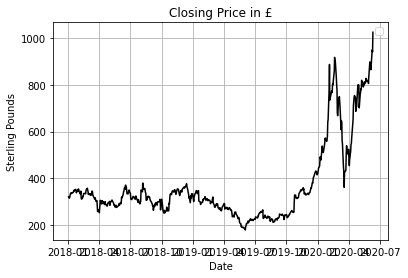

In [179]:
## Visualization
plt.figure()
plt.title('Closing Price in £')
plt.plot(stockData["Close"], color='black')
plt.xlabel('Date')
plt.ylabel('Sterling Pounds')
plt.legend()
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

Implement regression using Recurrent Neural Network

In [0]:
## Extract Clossing price
data = stockData.filter(['Close'])
dataset = data.values


In [0]:
## Preprocess the data
normalizer = MinMaxScaler(feature_range=(0,1)) # instantiate scaler
normalizedData = normalizer.fit_transform(dataset) # values between 0,1


In [207]:
## Create training data
trainingComponent = 0.8
trainingDataLength = math.ceil(len(dataset)*trainingComponent)
trainingData =  normalizedData[0:trainingDataLength, :]

# split training data into input/output
xTrain = []
yTrain = []

# populate
days = 60
for i in range(days,len(trainingData)):
  xTrain.append(trainingData[i-days:i, 0]) # past 60
  yTrain.append(trainingData[i, 0])

# make into numpy arrays
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

# reshape to fit model as LSTM expects 3 dim
xTrain.shape # currently 2 dim
xTrain = np.reshape(xTrain,(xTrain.shape[0],xTrain.shape[1],1)) #reshape into row, column, features
xTrain.shape # now 3dim


(432, 60, 1)

In [0]:
## Create testing data
testingData = normalizedData[trainingDataLength-days:, : ]

# split training data into input/output
xTest = []
yTest = dataset[trainingDataLength:, : ]

for i in range(days,len(testingData)):
  xTest.append(testingData[i-days:i, 0]) # past 60

# make into numpy arrays
xTest = np.array(xTest)
yTest = np.array(yTest)

# reshape to fit model as LSTM expects 3 dim
xTest = np.reshape(xTest , (xTest.shape[0], xTest.shape[1], 1))


In [209]:
## Creating LSTM model
model = Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(xTrain.shape[1],1)))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# compile model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 60, 256)           264192    
_________________________________________________________________
lstm_73 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_75 (Dense)             (None, 25)                6425      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 26        
Total params: 795,955
Trainable params: 795,955
Non-trainable params: 0
_________________________________________________________________


In [210]:
## Training model
model.fit(xTrain, yTrain, batch_size=100, epochs=50, validation_data=(xTest,yTest))

Epoch 1/50
5/5 [==============================] - 1s 129ms/step - loss: 0.0069 - val_loss: 460135.8125
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0018 - val_loss: 459882.3750
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 9.7121e-04 - val_loss: 460022.0938
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 9.9229e-04 - val_loss: 459894.7188
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 8.2459e-04 - val_loss: 459882.9688
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 5.4019e-04 - val_loss: 459862.2188
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 4.9104e-04 - val_loss: 459778.2188
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 4.5902e-04 - val_loss: 459790.0312
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 4.4603e-04 - val_loss: 459750.8125
Epoch 10/50
5/5 [==============================] - 0s

In [229]:
## Predictions using LSTM: Testing Data
predictions = model.predict(xTest)
predictions = normalizer.inverse_transform(predictions)

# Calculating RMSE
rmse =np.sqrt(np.mean(((predictions- yTest)**2)))
rmse

65.39262495624816

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


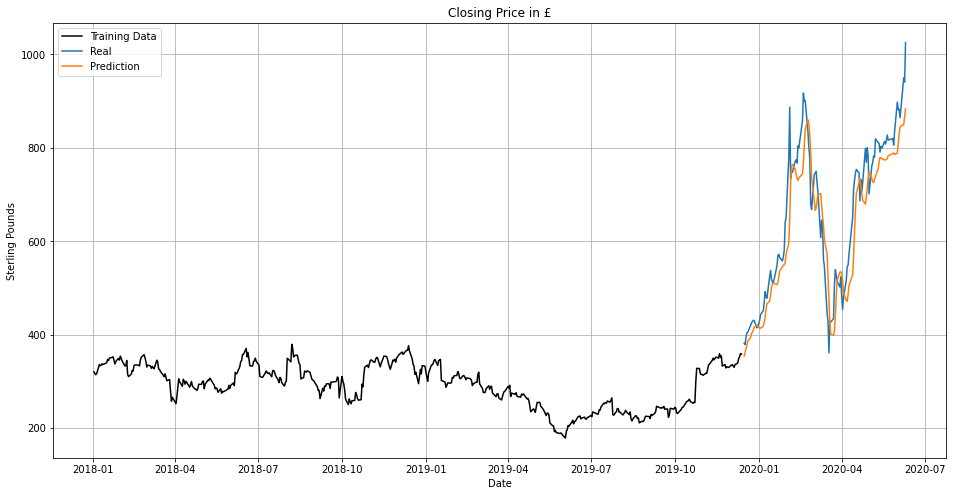

In [230]:
## Visualizing Results Testing Data
trainData = data[:trainingDataLength]
validation = data[trainingDataLength:]
validation['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Closing Price in £')
plt.plot(trainData['Close'], color='black')
plt.plot(validation[['Close','Predictions']])

plt.xlabel('Date')
plt.ylabel('Sterling Pounds')
plt.legend(['Training Data','Real','Prediction'])
plt.grid()

currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

In [249]:
## Using model to predict new data
start_date = '2018-06-09'
end_date = '2020-06-10'

stockName = 'AMZN'

newStockQuery = data.get_data_yahoo(stockName, start_date, end_date)
newStockQuery.head() 

# get closing price 
stockData = newStockQuery.filter(['Close'])

# get last 60 days
last60Days = stockData[-60:].values
normalizedData = normalizer.transform(last60Days)

# prepare new test data, normalize and reshape
xTest = []
xTest.append(normalizedData)

xTest = np.array(xTest)
xTest = np.reshape(xTest,(xTest.shape[0],xTest.shape[1],1))

# predict and reverse the normalization
predictedNew = model.predict(xTest) 
predictedNew = normalizer.inverse_transform(predictedNew)
print('predicted price: ' + str(predictedNew))

# Real value
realValue = data.get_data_yahoo(stockName, end_date, end_date)
print(realValue['Close'])


predicted price: [[2333.7725]]
Date
2020-06-10    2647.449951
Name: Close, dtype: float64
